# TESTS MODELES STANDARDS

## I- Création des classes et méthodes de calculs

In [7]:
import numpy as np
from scipy import *
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from math import *


class Inclusion():
    """
    Contient les informations propres à une inclusion (type, géométrie, comportement, etc...).
    """
    
    def __init__(self, type_inclusion, behavior, radius):
        """
        type_inclusion : (int), 0 pour des inclusions sphériques.
        radius : (float), valeur du rayon des inclusions sphériques. TODO : À remplacer par un paramètre plus général pour des inclusions de types différents. 
        behavior : (dict), contient les valeurs des paramètres de la matrice de comportement, pour le moment, K (bulk modulus) et G (shear modulus). TODO :  À modifier pour représenter des comportements non isotropes.
        """
        self.type_inclusion = type_inclusion
        self.radius = radius
        self.behavior = behavior
    
    def type_to_str(self):
        """
        Transforme un entier "type_inclusion" en la chaîne de caractères correspondante (exemple : 0 --> "spheres") 
        TODO : synchroniser cette fonction avec le main à l'aide d'un dictionnaire pour faciliter l'ajout de types d'inclusions
        """
        type_inclusion = self.type_inclusion
        if type_inclusion == 0:
            return "spheres"
    
    def __str__(self):
        """
        Présentation de l'instance.
        """
        str_type_inclusion = self.type_to_str()
        return "Inclusion : {}, radius : {}".format(str_type_inclusion, self.radius)

    def __repr__(self):
        return str(self)

    
class Microstructure():
    """
    Contient des informations sur la microstructure (comportement de la matrice, inclusions, etc..). TODO : à modifier pour prendre en compte la présence ou non d'une interphase, et d'autres paramètres de modèles plus avancés.
    Contient une fonction qui renvoie les bornes de Hashin-Shtrickman pour la microstructure en question 
    TODO : Généraliser ces bornes à n phases (et pas 2 comme c'est le cas ici)
    """
    
    def __init__(self, matrix_behavior, dict_inclusions=dict()):
        """
        list_inclusions : (dict), sous la forme [inclusion: f_i] avec inclusion une instance de classe Inclusion et f_i la fraction volumique de ce type d'inclusion.
        matrix_behavior : (dict), contient les valeurs des paramètres de la matrice de comportement, pour le moment, K (bulk modulus) et G (shear modulus). TODO :  À modifier pour représenter des comportements non isotropes.
        """
        self.dict_inclusions = dict_inclusions
        self.matrix_behavior = matrix_behavior
        # Calcul de la fraction volumique de matrice f_m
        self.f_matrix = self.compute_fm()
        
    def __str__(self):
        string = "Microstructure\nf_m = {:.2f}, matrix".format(self.f_matrix)
        dict_inclusions = self.dict_inclusions
        # Présentation de toutes les inclusions contenues dans la microstructure
        for inclusion in dict_inclusions.keys():
            fi = dict_inclusions[inclusion]
            string += "\nf_i = {}, ".format(fi) + str(inclusion)
        return string

    def compute_fm(self):
        """
        1/ Vérifie si la liste des inclusions donnée est cohérente (i.e : la somme des fractions volumiques des inclusions est inférieure à 1). Si ce n'est pas le cas, génère une erreur.
        2/ Si aucune erreur n'est générée, calcule la fraction volumique de matrice.
        """
        total_fi = 0 # Total des fractions volumiques d'inclusions
        dict_inclusions = self.dict_inclusions
        for inclusion in dict_inclusions.keys():
            fi = dict_inclusions[inclusion]
            total_fi += fi
        if total_fi > 1:
            raise NameError("Inconsistent list of volumic fractions")
        else :
            f_m = 1 - total_fi
            return f_m
        
     ## CALCUL DES BORNES DE HASHIN-SHTRICKMAN ##########  
    
    def khs(k1, g1, c1, k2, g2, c2):
        numerator = c2*(k2-k1)
        denominator = 1+3*c1*(k2-k1)/(4*g1+3*k1)
        return k1+numerator/denominator
    
    def ghs(k1, g1, c1, k2, g2, c2):
        numerator = c2*(g2-g1)
        denominator = 1+6*c1*(g2-g1)*(k1+2*g1)/((3*k1+4*g1)*5*g1)
        return g1+numerator/denominator
    
    def khsporous(k,g,c):
        numerator = 4*(1-c)*k*g
        denominator = 4*g+3*c*k
        return numerator/denominator
    
    def ghsporous(k,g,c):
        numerator = (1-c)*(8*g+9*k)*g
        denominator = 4*g*(2+3*c)+3*k*(3+2*c)
        return numerator/denominator
        
    def Hashin_bounds(self):
        """
        Donne les bornes de Hashin-Shtrikman pour 1 seule phase, isotrope
        TODO : ajouter le cas des inclusion multiples
        """
        fm=self.f_matrix
        f=1-fm
        km,gm=self.matrix_behavior["K"],self.matrix_behavior["G"]
        
        for inclusion in self.dict_inclusions.keys():
            kf,gf=inclusion.behavior["K"],inclusion.behavior["G"]
            
            if kf<10**-5 and gf<10**-5 :
                ksup=max(Microstructure.khsporous(km,gm,f),Microstructure.khsporous(km,gm,f))
                kinf=min(Microstructure.khsporous(km,gm,f),Microstructure.khsporous(km,gm,f))
                gsup=max(Microstructure.ghsporous(km,gm,f),Microstructure.ghsporous(km,gm,f))
                ginf=min(Microstructure.ghsporous(km,gm,f),Microstructure.ghsporous(km,gm,f))
           
            else :        
                ksup=max(Microstructure.khs(km,gm,fm,kf,gf,f),Microstructure.khs(kf,gf,f,km,gm,fm))
                kinf=min(Microstructure.khs(km,gm,fm,kf,gf,f),Microstructure.khs(kf,gf,f,km,gm,fm))
                gsup=max(Microstructure.ghs(km,gm,fm,kf,gf,f),Microstructure.ghs(kf,gf,f,km,gm,fm))
                ginf=min(Microstructure.ghs(km,gm,fm,kf,gf,f),Microstructure.ghs(kf,gf,f,km,gm,fm))
            
        
        return { 'Ginf' : ginf, 'Gsup' : gsup, 'Kinf' : kinf, 'Ksup' : ksup }
   


class Mori_Tanaka:
    """
    TODO : vérifier si le modèle s'applique aussi à d'autres types d'inclusion, pour le moment seules des inclusions sphériques isotropes sont prises en compte pour tester le code.
    Modèle de Mori-Tanaka. Contient :
    - Une fonction qui vérifie si le modèle est appliquable à une microstructure.
    - Une fonction de description du modèle (TODO : écrire une fonction qui renvoie une description du modèle sous forme de str et qui pourrait être appelée dans le main)
    - Un fonction qui renvoie le comportement homogénéisé de la microstructure.
    - Des fonctions qui calculent une caractéristique particulière (fraction volumique d'une inclusion, rayon d'une inclusion, comportement d'une inclusion, etc..) à partir d'un comportement homogénéisé cible (TODO)
    """
    
    def __init__(self):
        """
        Définition des hypothèses du modèle.
        """
        self.type_inclusion = 0
        self.behavior_condition = ["K", "G"] # Le modèle s'applique sur des microstructures dont les inclusions et la matrice sont isotropes
        self.n_inclusions = 1 # Nombre d'inclusions de natures différentes 
        
    def __str__(self):
        """
        Description textuelle du modèle.
        """
        return "Modèle de Mori-Tanaka"
    
    def __repr__(self):
        """
        Description textuelle du modèle.
        """
        return str(self)
    
    def check_hypothesis(self, microstructure):
        """
        Vérifies si la microstructure vérifie les hypothèses du modèle, renvoie un boolées. 
        TODO : Éventuellement généraliser cette fonction en l'incorporant dans une classe mère Model pour qu'elle s'applique à tous les modèles.
        """
        dict_inclusions = microstructure.dict_inclusions
        inclusions = dict_inclusions.keys()
        n_inclusions = len(inclusions)
        # vérification du nombre d'inclusions
        if n_inclusions > self.n_inclusions:
            # Le modèle ne peut pas traiter de microstructures avec autant d'inclusions de natures différentes
             raise NameError("Wrong number of inclusion")
             return False
        for inclusion in dict_inclusions.keys():
            # Vérification du type d'inclusion
            if inclusion.type_inclusion != self.type_inclusion:
                raise NameError("Wrong type of inclusion or microstructure")
                return False
            # vérification du comportement des inclusions
            behavior = inclusion.behavior
            if list(behavior.keys()) != self.behavior_condition:
                print (list(behavior.keys()) , self.behavior_condition)
                raise NameError("Inclusion and microstructure behavior incompatible")
                return False
        # Vérification su comportement de la matrice
        if list(microstructure.matrix_behavior.keys()) != self.behavior_condition:
            raise NameError("Inclusion and microstructure behavior incompatible")
            return False
        # À ce stade, toutes les conditions ont été vérifiées
        return True
    
    def compute_h_behavior(self, microstructure):
        """
        Calcule le comportement homogénéisé équivalent de la microstructure. Renvoie un dict avec les paramètres calculés. Pour le moment, ne calcul que le module de cisaillement.
        TODO : compléter avec le calcul complet (K et G)
        """
        compatible = self.check_hypothesis(microstructure)
        if not compatible:
            raise NameError("The microstructure does not match the model hypothesis")
        Cm = microstructure.matrix_behavior
        dict_inclusions = microstructure.dict_inclusions
        inclusion = list(dict_inclusions.keys())[0] #Inclusion unique ici
        Cf = inclusion.behavior
        Gm, Km = Cm['G'], Cm['K']
        Gf, Kf = Cf['G'], Cf['K']
        f = dict_inclusions[inclusion]
        
        denominator = 5*Gm*(3*Km+4*Gm)+6*(1-f)*(Gf-Gm)*(Km+2*Gm)
        numerator = 5*f*Gm*(Gf-Gm)*(3*Km+4*Gm)
        Gh = Gm + numerator/denominator
        
        denominator = 3*Km+4*Gm+3*(1-f)*(Kf-Km)
        numerator = f*(Kf-Km)*(3*Km+4*Gm)
        Kh = Km + numerator/denominator
        return {'K' : Kh, 'G' : Gh}
    

    
    def check_bounds(self,microstructure):
        Behavior_h=self.compute_h_behavior(microstructure)
        Gh = Behavior_h['G']
        Kh = Behavior_h['K']
        Bounds=microstructure.Hashin_bounds()
        Gsup = Bounds['Gsup']
        Ginf = Bounds['Ginf']
        Ksup = Bounds['Ksup']
        Kinf = Bounds['Kinf']
        if Gh < Ginf or Gh > Gsup : 
            raise NameError("G out of Hashin-Shtrikman bounds")
            return False
        if Kh < Kinf or Kh > Ksup :
            raise NameError("K out of Hashin-Shtrikman bounds")
            return False
        return True
    
class Eshelby_Approximation:
    """
    TODO : vérifier si le modèle s'applique aussi à d'autres types d'inclusion, pour le moment seules des inclusions sphériques isotropes sont prises en compte pour tester le code.
    Modèle de Mori-Tanaka. Contient :
    - Une fonction qui vérifie si le modèle est appliquable à une microstructure.
    - Une fonction de description du modèle (TODO : écrire une fonction qui renvoie une description du modèle sous forme de str et qui pourrait être appelée dans le main)
    - Un fonction qui renvoie le comportement homogénéisé de la microstructure.
    - Des fonctions qui calculent une caractéristique particulière (fraction volumique d'une inclusion, rayon d'une inclusion, comportement d'une inclusion, etc..) à partir d'un comportement homogénéisé cible (TODO)
    """
    
    def __init__(self):
        """
        Définition des hypothèses du modèle.
        """
        self.type_inclusion = 0
        self.behavior_condition = ["K", "G"] # Le modèle s'applique sur des microstructures dont les inclusions et la matrice sont isotropes
        self.n_inclusions = 1 # Nombre d'inclusions de natures différentes 
        
    def __str__(self):
        """
        Description textuelle du modèle.
        """
        return "Modèle de Mori-Tanaka"
    
    def __repr__(self):
        """
        Description textuelle du modèle.
        """
        return str(self)
    
    def check_hypothesis(self, microstructure):
        """
        Vérifies si la microstructure vérifie les hypothèses du modèle, renvoie un boolées. 
        TODO : Éventuellement généraliser cette fonction en l'incorporant dans une classe mère Model pour qu'elle s'applique à tous les modèles.
        """
        dict_inclusions = microstructure.dict_inclusions
        inclusions = dict_inclusions.keys()
        n_inclusions = len(inclusions)
        # vérification du nombre d'inclusions
        if n_inclusions > self.n_inclusions:
            # Le modèle ne peut pas traiter de microstructures avec autant d'inclusions de natures différentes
             raise NameError("Wrong number of inclusion")
             return False
        for inclusion in dict_inclusions.keys():
            # Vérification du type d'inclusion
            if inclusion.type_inclusion != self.type_inclusion:
                raise NameError("Wrong type of inclusion or microstructure")
                return False
            # vérification du comportement des inclusions
            behavior = inclusion.behavior
            if list(behavior.keys()) != self.behavior_condition:
                print (list(behavior.keys()) , self.behavior_condition)
                raise NameError("Inclusion and microstructure behavior incompatible")
                return False
        # Vérification su comportement de la matrice
        if list(microstructure.matrix_behavior.keys()) != self.behavior_condition:
            raise NameError("Inclusion and microstructure behavior incompatible")
            return False
        # À ce stade, toutes les conditions ont été vérifiées
        return True
    
    def compute_h_behavior(self, microstructure):
        """
        Calcule le comportement homogénéisé équivalent de la microstructure. Renvoie un dict avec les paramètres calculés. Pour le moment, ne calcul que le module de cisaillement.
        TODO : compléter avec le calcul complet (K et G)
        """
        compatible = self.check_hypothesis(microstructure)
        if not compatible:
            raise NameError("The microstructure does not match the model hypothesis")
        Cm = microstructure.matrix_behavior
        dict_inclusions = microstructure.dict_inclusions
        inclusion = list(dict_inclusions.keys())[0] #Inclusion unique ici
        Cf = inclusion.behavior
        Gm, Km = Cm['G'], Cm['K']
        Gf, Kf = Cf['G'], Cf['K']
        f = dict_inclusions[inclusion]
        
        denominator = 3*Km*(3*Gm+2*Gf) + 4*Gm*(2*Gm+3*Gf)
        numerator = 5*f*Gm*(Gf-Gm)*(3*Km+4*Gm)
        Gh = Gm + numerator/denominator
        
        denominator = 3*Kf+4*Gm
        numerator = f*(Kf-Km)*(3*Km+4*Gm)
        Kh = Km + numerator/denominator
        
        return {'K' : Kh, 'G' : Gh}
    
    def check_bounds(self,microstructure):
        Behavior_h=self.compute_h_behavior(microstructure)
        Gh = Behavior_h['G']
        Kh = Behavior_h['K']
        Bounds=microstructure.Hashin_bounds()
        Gsup = Bounds['Gsup']
        Ginf = Bounds['Ginf']
        Ksup = Bounds['Ksup']
        Kinf = Bounds['Kinf']
        if Gh < Ginf or Gh > Gsup : 
            raise NameError("G out of Hashin-Shtrikman bounds")
            return False
        if Kh < Kinf or Kh > Ksup :
            raise NameError("K out of Hashin-Shtrikman bounds")
            return False
        return True
    

class Differential_Scheme:
    """
    TODO : 
    vérifier si le modèle s'applique aussi à d'autres types d'inclusion, pour le moment seules des inclusions sphériques isotropes sont prises en compte pour tester le code. 
    Modèle différentiel. Contient :
    - Une fonction qui vérifie si le modèle est appliquable à une microstructure.
    - Une fonction de description du modèle (TODO : écrire une fonction qui renvoie une description du modèle sous forme de str et qui pourrait être appelée dans le main)
    - Un fonction qui renvoie le comportement homogénéisé de la microstructure.
    - Une fonction qui vérifie que le comportement homogénéisé se trouve dans les bornes de Hashin-Shtrickman.
    """
    
    def __init__(self):
        """
        Définition des hypothèses du modèle.
        """
        self.type_inclusion = 0
        self.behavior_condition = ["K", "G"] # Le modèle s'applique sur des microstructures dont les inclusions et la matrice sont isotropes
        self.n_inclusions = 1 # Nombre d'inclusions de natures différentes 
        
    def __str__(self):
        """
        Description textuelle du modèle.
        """
        return "Modèle de Mori-Tanaka"
    
    def __repr__(self):
        """
        Description textuelle du modèle.
        """
        return str(self)
    
    def check_hypothesis(self, microstructure):
        """
        Vérifies si la microstructure vérifie les hypothèses du modèle, renvoie un boolées. 
        TODO : Éventuellement généraliser cette fonction en l'incorporant dans une classe mère Model pour qu'elle s'applique à tous les modèles.
        """
        dict_inclusions = microstructure.dict_inclusions
        inclusions = dict_inclusions.keys()
        n_inclusions = len(inclusions)
        # vérification du nombre d'inclusions
        if n_inclusions > self.n_inclusions:
            # Le modèle ne peut pas traiter de microstructures avec autant d'inclusions de natures différentes
             raise NameError("Wrong number of inclusion")
             return False
        for inclusion in dict_inclusions.keys():
            # Vérification du type d'inclusion
            if inclusion.type_inclusion != self.type_inclusion:
                raise NameError("Wrong type of inclusion or microstructure")
                return False
            # vérification du comportement des inclusions
            behavior = inclusion.behavior
            if list(behavior.keys()) != self.behavior_condition:
                print (list(behavior.keys()) , self.behavior_condition)
                raise NameError("Inclusion and microstructure behavior incompatible")
                return False
        # Vérification su comportement de la matrice
        if list(microstructure.matrix_behavior.keys()) != self.behavior_condition:
            raise NameError("Inclusion and microstructure behavior incompatible")
            return False
        # À ce stade, toutes les conditions ont été vérifiées
        return True
    
    ## Fonctions utiles au calcul du comportement homogénéisé
    
    def deriv(Module,f):
        K,G,Kf,Gf=Module[0],Module[1],Module[2],Module[3]
        mu=(3*K-2*G)/(6*K+2*G)
        
        numerator=K-Kf
        denominator=(1-f)*(1+(Kf-K)/(K+4*G/3))
        dK=-numerator/denominator
        
        numerator=15*(1-mu)*(G-Gf)
        denominator=(1-f)*(7-5*mu+2*(4-5*mu)*Gf/G)
        dG=-numerator/denominator
        
        return np.array([dK,dG,0,0])
    
    def khs(k1, g1, c1, k2, g2, c2):
        numerator = c2*(k2-k1)*(4*g1+3*k1)
        denominator = (4*g1+3*k1)+3*c1*(k2-k1)
        return k1+numerator/denominator
    
    def ghs(k1, g1, c1, k2, g2, c2):
        numerator = c2*(g2-g1)*((3*k1+4*g1)*5*g1)
        denominator = ((3*k1+4*g1)*5*g1)+6*c1*(g2-g1)*(k1+2*g1)
        return g1+numerator/denominator
    
    def compute_h_behavior(self, microstructure):
        """
        Calcule le comportement homogénéisé équivalent de la microstructure. Renvoie un dict avec les paramètres calculés. Pour le moment, ne calcul que le module de cisaillement.
        TODO : compléter avec le calcul complet (K et G)
        """
        compatible = self.check_hypothesis(microstructure)
        if not compatible:
            raise NameError("The microstructure does not match the model hypothesis")
        Cm = microstructure.matrix_behavior
        dict_inclusions = microstructure.dict_inclusions
        inclusion = list(dict_inclusions.keys())[0] #Inclusion unique ici
        Cf = inclusion.behavior
        Gm, Km = Cm['G'], Cm['K']
        Gf, Kf = Cf['G'], Cf['K']
        f_finale = dict_inclusions[inclusion]
        
        npoints=1000
        dc=0.9/npoints
        f=np.linspace(0,f_finale,npoints)
        Module_Initial=np.array([Km,Gm,Kf,Gf])
        Module=odeint(Differential_Scheme.deriv,Module_Initial,f)
        Module_final=Module[npoints-1]
        Kh,Gh,Kf,Gf=Module_final   
        return {'K' : Kh, 'G' : Gh}
    

    
    def check_bounds(self,microstructure):
        Behavior_h=self.compute_h_behavior(microstructure)
        Gh = Behavior_h['G']
        Kh = Behavior_h['K']
        Bounds=microstructure.Hashin_bounds()
        Gsup = Bounds['Gsup']
        Ginf = Bounds['Ginf']
        Ksup = Bounds['Ksup']
        Kinf = Bounds['Kinf']
        if Gh < Ginf or Gh > Gsup : 
            raise NameError("G out of Hashin-Shtrikman bounds")
            return False
        if Kh < Kinf or Kh > Ksup :
            raise NameError("K out of Hashin-Shtrikman bounds")
            return False
        return True

# Tests 

In [10]:
Km,Gm,Kf,Gf=10,10,105,105
f = 1
inclusion=Inclusion(0, {"K":Kf, "G":Gf}, 1)
microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
Bounds=microstructure.Hashin_bounds()
Ch=Differential_Scheme().compute_h_behavior(microstructure)
print(Ch)
Ch=Mori_Tanaka().compute_h_behavior(microstructure)
print(Ch)
Ch=Eshelby_Approximation().compute_h_behavior(microstructure)
print(Ch)

{'K': 104.99999734363367, 'G': 105.00000032411427}
{'K': 105.0, 'G': 105.0}


NameError: name 'Eshelby' is not defined

## Cas poreux pour les différents schémas

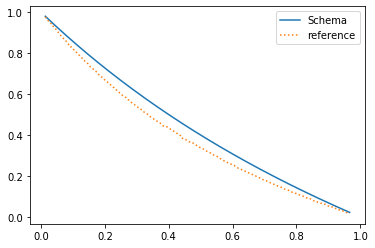

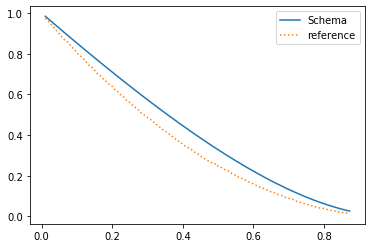

In [16]:
## Données
FMT =  [0.0135, 0.0168, 0.0202, 0.0236, 0.0269, 0.0336, 0.0337, 0.0404, 0.0437, 0.0471, 0.0505, 0.0538, 0.0572, 0.0606, 0.0639, 0.0673, 0.074, 0.0774, 0.0808, 0.0841, 0.0875, 0.0942, 0.0942, 0.1009, 0.1043, 0.1077, 0.1144, 0.1177, 0.1211, 0.1245, 0.1312, 0.1346, 0.1379, 0.1446, 0.148, 0.1514, 0.1547, 0.1615, 0.1648, 0.1715, 0.1749, 0.1783, 0.185, 0.1883, 0.1951, 0.1984, 0.2018, 0.2085, 0.2119, 0.2186, 0.2219, 0.2287, 0.232, 0.2387, 0.2421, 0.2488, 0.2522, 0.2589, 0.2656, 0.269, 0.2757, 0.2791, 0.2858, 0.2925, 0.2958, 0.3026, 0.3093, 0.316, 0.3193, 0.3261, 0.3328, 0.3395, 0.3428, 0.3496, 0.3563, 0.363, 0.3697, 0.373, 0.3764, 0.3798, 0.3865, 0.3932, 0.3965, 0.4032, 0.41, 0.4167, 0.42, 0.4234, 0.4301, 0.4368, 0.4368, 0.4402, 0.4469, 0.4536, 0.4603, 0.4637, 0.4703, 0.4771, 0.4838, 0.4905, 0.4971, 0.5039, 0.5106, 0.5173, 0.524, 0.5307, 0.5373, 0.5441, 0.5509, 0.5575, 0.5643, 0.571, 0.5777, 0.5844, 0.5911, 0.5977, 0.6045, 0.6112, 0.6179, 0.6246, 0.6313, 0.638, 0.6414, 0.6481, 0.6548, 0.6615, 0.6649, 0.6716, 0.6783, 0.685, 0.6917, 0.6984, 0.705, 0.7118, 0.7185, 0.7252, 0.7319, 0.7386, 0.742, 0.7487, 0.7553, 0.7621, 0.7688, 0.7755, 0.7822, 0.7889, 0.7955, 0.8023, 0.8056, 0.8124, 0.8191, 0.8258, 0.8325, 0.8357, 0.8425, 0.8492, 0.8526, 0.8593, 0.866, 0.8727, 0.8794, 0.8827, 0.8894, 0.8961, 0.9028, 0.9062, 0.9129, 0.9196, 0.9263, 0.933, 0.9397, 0.9464, 0.9531, 0.9564, 0.963, 0.9665]
KMT =  [0.9763, 0.9695, 0.9627, 0.956, 0.9492, 0.9424, 0.9357, 0.9289, 0.9221, 0.9153, 0.9085, 0.9018, 0.895, 0.8881, 0.8815, 0.8747, 0.8679, 0.8611, 0.8544, 0.8476, 0.8408, 0.834, 0.8273, 0.8205, 0.8136, 0.807, 0.8002, 0.7934, 0.7866, 0.7799, 0.7731, 0.7663, 0.7596, 0.7528, 0.746, 0.7391, 0.7325, 0.7257, 0.7189, 0.7122, 0.7054, 0.6985, 0.6918, 0.6851, 0.6783, 0.6715, 0.6646, 0.658, 0.6512, 0.6444, 0.6377, 0.6309, 0.624, 0.6174, 0.6106, 0.6038, 0.597, 0.5903, 0.5835, 0.5767, 0.5699, 0.5632, 0.5564, 0.5495, 0.5429, 0.5361, 0.5293, 0.5226, 0.5158, 0.509, 0.5023, 0.4955, 0.4887, 0.4819, 0.4752, 0.4684, 0.4616, 0.4583, 0.4549, 0.4481, 0.4413, 0.4413, 0.438, 0.4312, 0.4243, 0.4177, 0.4143, 0.4109, 0.4041, 0.3974, 0.3906, 0.3872, 0.3804, 0.377, 0.3703, 0.3669, 0.3669, 0.3601, 0.3534, 0.3466, 0.3397, 0.3364, 0.3296, 0.3229, 0.3161, 0.3128, 0.306, 0.2992, 0.2958, 0.2891, 0.2823, 0.2755, 0.2722, 0.2654, 0.262, 0.2553, 0.2519, 0.2451, 0.2383, 0.2349, 0.2282, 0.2248, 0.2214, 0.218, 0.2113, 0.2079, 0.2045, 0.2011, 0.1944, 0.191, 0.1842, 0.1808, 0.1775, 0.1707, 0.1673, 0.1639, 0.1572, 0.1538, 0.1504, 0.147, 0.1437, 0.1369, 0.1335, 0.1301, 0.1234, 0.12, 0.1166, 0.1132, 0.1098, 0.1065, 0.1031, 0.0963, 0.0929, 0.0896, 0.0896, 0.0828, 0.0794, 0.0794, 0.0727, 0.0693, 0.0659, 0.0625, 0.0625, 0.0558, 0.0524, 0.049, 0.049, 0.0422, 0.0422, 0.0355, 0.0321, 0.0287, 0.0253, 0.022, 0.0186, 0.0152]
FDIF =  [0.0103, 0.0137, 0.0172, 0.0206, 0.0241, 0.0275, 0.0309, 0.0344, 0.0378, 0.0412, 0.0447, 0.0481, 0.0515, 0.055, 0.0584, 0.0619, 0.0653, 0.0722, 0.0756, 0.079, 0.0825, 0.0859, 0.0893, 0.0928, 0.0962, 0.0997, 0.1031, 0.1065, 0.1134, 0.1168, 0.1203, 0.1237, 0.1271, 0.1306, 0.134, 0.1409, 0.1443, 0.1478, 0.1512, 0.1546, 0.1581, 0.1649, 0.1684, 0.1718, 0.1753, 0.1787, 0.1856, 0.189, 0.1924, 0.1993, 0.2027, 0.2062, 0.2096, 0.2165, 0.2199, 0.2234, 0.2268, 0.2337, 0.2371, 0.2405, 0.2474, 0.2509, 0.2543, 0.2612, 0.2646, 0.268, 0.2749, 0.2784, 0.2818, 0.2887, 0.2921, 0.299, 0.3024, 0.3093, 0.3127, 0.3195, 0.323, 0.3299, 0.3333, 0.3402, 0.3436, 0.3505, 0.354, 0.3608, 0.3643, 0.3711, 0.3746, 0.3814, 0.3849, 0.3918, 0.3952, 0.4021, 0.4055, 0.4123, 0.4192, 0.4261, 0.4296, 0.4364, 0.4433, 0.4502, 0.4536, 0.4605, 0.4674, 0.4742, 0.4811, 0.4845, 0.488, 0.4948, 0.4948, 0.5017, 0.5051, 0.512, 0.5154, 0.5223, 0.5292, 0.5361, 0.5394, 0.5464, 0.5497, 0.5533, 0.5601, 0.5636, 0.5704, 0.5773, 0.5842, 0.5911, 0.5979, 0.6048, 0.6117, 0.6186, 0.6254, 0.6322, 0.6392, 0.646, 0.6529, 0.6598, 0.6667, 0.6735, 0.6804, 0.6873, 0.6942, 0.701, 0.7079, 0.7147, 0.7216, 0.7285, 0.7354, 0.7423, 0.749, 0.756, 0.7629, 0.7698, 0.7766, 0.7835, 0.7904, 0.7973, 0.8041, 0.811, 0.8178, 0.8247, 0.8316, 0.8385, 0.8454, 0.8521, 0.8591, 0.866, 0.8729]
KDIF =  [0.9742, 0.9673, 0.9639, 0.9569, 0.9501, 0.9433, 0.9364, 0.9295, 0.9226, 0.9157, 0.9089, 0.902, 0.8951, 0.8881, 0.8813, 0.8745, 0.8676, 0.8607, 0.8538, 0.8469, 0.8401, 0.8332, 0.8263, 0.8194, 0.8125, 0.8056, 0.7988, 0.7919, 0.785, 0.7781, 0.7713, 0.7644, 0.7574, 0.7506, 0.7437, 0.7368, 0.73, 0.7231, 0.7162, 0.7093, 0.7024, 0.6955, 0.6886, 0.6818, 0.6749, 0.668, 0.6611, 0.6543, 0.6474, 0.6404, 0.6336, 0.6267, 0.6198, 0.613, 0.6061, 0.5992, 0.5923, 0.5854, 0.5785, 0.5716, 0.5648, 0.5579, 0.551, 0.5441, 0.5372, 0.5304, 0.5234, 0.5166, 0.5097, 0.5028, 0.4959, 0.4889, 0.4821, 0.4753, 0.4684, 0.4615, 0.4546, 0.4477, 0.4408, 0.4339, 0.427, 0.4202, 0.4133, 0.4064, 0.3995, 0.3926, 0.3857, 0.3788, 0.3719, 0.3685, 0.3616, 0.3547, 0.3477, 0.3409, 0.334, 0.3271, 0.3203, 0.3134, 0.3065, 0.2995, 0.2927, 0.2858, 0.2789, 0.272, 0.2651, 0.2617, 0.2582, 0.2582, 0.2513, 0.2478, 0.2444, 0.2375, 0.2341, 0.2272, 0.2237, 0.2168, 0.2099, 0.2065, 0.1996, 0.1961, 0.1927, 0.1892, 0.1857, 0.1788, 0.172, 0.1685, 0.1616, 0.1547, 0.1512, 0.1443, 0.1409, 0.134, 0.1305, 0.1236, 0.1201, 0.1167, 0.1098, 0.1063, 0.1028, 0.0959, 0.0925, 0.089, 0.0856, 0.0821, 0.0752, 0.0717, 0.0683, 0.0648, 0.0613, 0.0579, 0.0544, 0.0509, 0.0475, 0.044, 0.0405, 0.0405, 0.037, 0.0336, 0.0301, 0.0301, 0.0266, 0.0231, 0.0197, 0.0196, 0.0196, 0.0161, 0.0127]
KHMT,KHDIF = [],[]

for i in range(len(FMT)):   
    f=FMT[i]
    Em=3
    mum=0
    Km=Em/(3-6*mum)
    Gm=Em/(2+2*mum)
    K=0
    G=0
    inclusion=Inclusion(0, {"K":K, "G":G}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    Ch=Mori_Tanaka().compute_h_behavior(microstructure)
    Kh=Ch['K']/Km
    KHMT.append(Kh)
    
for i in range(len(FDIF)): 
    f=FDIF[i]
    Em=10
    mum=0
    Km=Em/(3-6*mum)
    Gm=Em/(2+2*mum)
    K=0
    G=0
    inclusion=Inclusion(0, {"K":K, "G":G}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    Ch=Differential_Scheme().compute_h_behavior(microstructure)
    Kh=Ch['K']/Km
    KHDIF.append(Kh)

plt.plot(FMT,KHMT,label='Schema')
plt.plot(FMT,KMT,':',label='reference')
plt.legend()
plt.show()

plt.plot(FDIF,KHDIF,label='Schema')
plt.plot(FDIF,KDIF,':',label='reference')
plt.legend()
plt.show()
   

## Modèle d'Eshelby

### PROBLEME LE RESULTAT SORT TOUJOURS DES BORNES DE H-S

### Inclusion rigide

Référence : simplification de la formule : à trouver dans la littérature

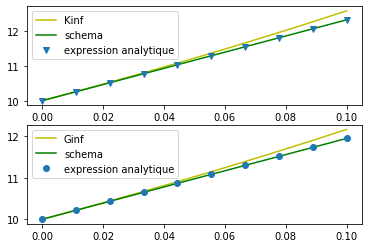

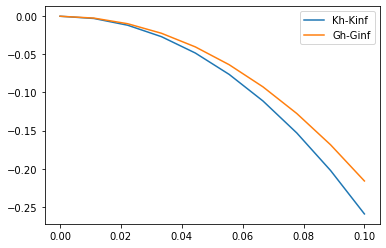

In [29]:
F=np.linspace(0,0.1,10)
Km,Gm,Kf,Gf=10,10,10**15,10**15
KEsh,GEsh,Kform,Gform=[],[],[],[]
Kinf,Ksup,Gsup,Ginf = [],[],[],[]

for i in range(len(F)):
    f=F[i]
    inclusion=Inclusion(0, {"K":Kf, "G":Gf}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    model = Eshelby_Approximation()
    Ch=model.compute_h_behavior(microstructure)
    KEsh.append(Ch['K'])
    GEsh.append(Ch['G'])
    
    k=Km+f*(3*Km+4*Gm)/3
    g=Gm+5*f*Gm*(3*Km+4*Gm)/(6*Km+12*Gm)
    Kform.append(k)
    Gform.append(g)    
    
    Bounds=microstructure.Hashin_bounds()
    Gsup.append(Bounds['Gsup'])
    Ginf.append(Bounds['Ginf'])
    Ksup.append(Bounds['Ksup'])
    Kinf.append(Bounds['Kinf'])


plt.subplot(2,1,1)
#plt.plot(F,Ksup,'r',label='Gsup')
plt.plot(F,Kinf,'y',label='Kinf')
plt.plot(F,KEsh,'g',label='schema')
plt.plot(F,Kform,'v',label='expression analytique')
plt.legend()
plt.subplot(2,1,2)
#plt.plot(F,Gsup,'r',label='Gsup')
plt.plot(F,Ginf,'y',label='Ginf')
plt.plot(F,GEsh,'g',label='schema')
plt.plot(F,Gform,'o',label='expression analytique')
plt.legend()
plt.show()

Gdiff = np.array(GEsh)-np.array(Ginf)
Kdiff = np.array(KEsh)-np.array(Kinf) 
plt.plot(F,Kdiff,label='Kh-Kinf')
plt.plot(F,Gdiff,label='Gh-Ginf')
plt.legend()
plt.show()

## Inclusion rigide et matrice incompressible

Reference : formule simplifiée

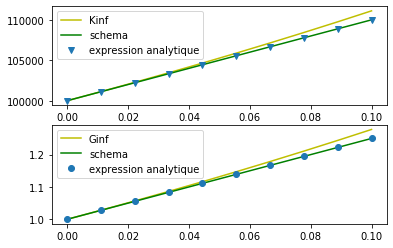

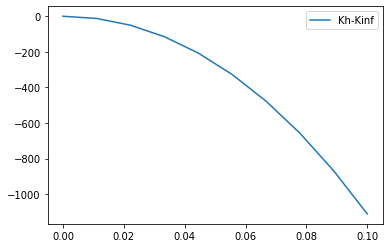

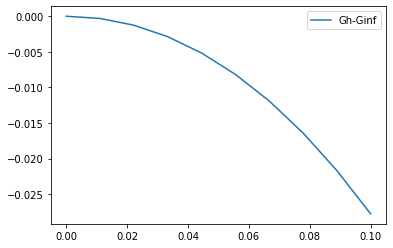

In [21]:
F=np.linspace(0,0.1,10)
Km,Gm,Kf,Gf=100000,1,10**15,10**15
KEsh,GEsh,Kform,Gform=[],[],[],[]
Kinf,Ksup,Gsup,Ginf = [],[],[],[]

for i in range(len(F)):
    f=F[i]
    inclusion=Inclusion(0, {"K":Kf, "G":Gf}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    model = Eshelby_Approximation()
    Ch=model.compute_h_behavior(microstructure)
    KEsh.append(Ch['K'])
    GEsh.append(Ch['G'])
    
    k=Km+f*Km
    g=Gm+5*f*Gm/2
    Kform.append(k)
    Gform.append(g)    
    
    Bounds=microstructure.Hashin_bounds()
    Gsup.append(Bounds['Gsup'])
    Ginf.append(Bounds['Ginf'])
    Ksup.append(Bounds['Ksup'])
    Kinf.append(Bounds['Kinf'])


plt.subplot(2,1,1)
#plt.plot(F,Ksup,'r',label='Gsup')
plt.plot(F,Kinf,'y',label='Kinf')
plt.plot(F,KEsh,'g',label='schema')
plt.plot(F,Kform,'v',label='expression analytique')
plt.legend()
plt.subplot(2,1,2)
#plt.plot(F,Gsup,'r',label='Gsup')
plt.plot(F,Ginf,'y',label='Ginf')
plt.plot(F,GEsh,'g',label='schema')
plt.plot(F,Gform,'o',label='expression analytique')
plt.legend()
plt.show()

Gdiff = np.array(GEsh)-np.array(Ginf)
Kdiff = np.array(KEsh)-np.array(Kinf) 
plt.plot(F,Kdiff,label='Kh-Kinf')
plt.legend()
plt.show()
plt.plot(F,Gdiff,label='Gh-Ginf')
plt.legend()
plt.show()

## Schéma Différentiel

### Comparaison intégrale/itération

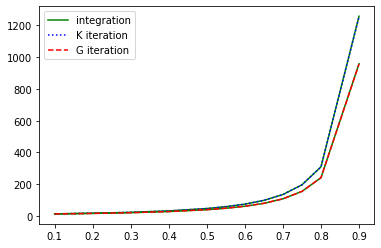

In [20]:
npoints=10000
F=[0.1,0.2,0.3,0.4,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.9]
Km,Gm,Kf,Gf=10,10,10**15,10**15
KH,GH,KT,GT=[],[],[],[]

for i in range(len(F)):
    f=F[i]
    inclusion=Inclusion(0, {"K":Kf, "G":Gf}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    model = Differential_Scheme()
    Ch=model.compute_h_behavior(microstructure)
    KH.append(Ch['K'])
    GH.append(Ch['G'])
    
    dc=f/npoints
    K,G=Km,Gm
    c=0
    for i in range (npoints):
        dK,dG,dKf,dGf=Differential_Scheme.deriv([K,G,Kf,Gf],c)
        K+=dc*dK
        G+=dc*dG
        c+=dc
    KT.append(K)
    GT.append(G)    

plt.plot(F,KH,'g',label='integration')
plt.plot(F,KT,':b',label='K iteration')
plt.plot(F,GH,'g')
plt.plot(F,GT,'--r',label='G iteration')
plt.legend()
plt.show()

### Inclusion parfaitement rigide et concentration pas trop élevée

Référence :  [Christensen,  R.M.,  1990.  A critical evaluation for a class of micromechanics models].

Equation (7) and (8) p5

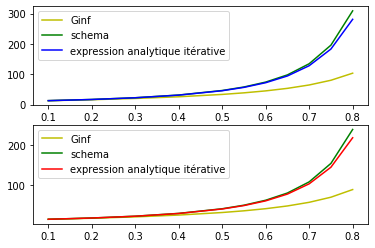

In [77]:
npoints=100
F=[0.1,0.2,0.3,0.4,0.5,0.55,0.6,0.65,0.7,0.75,0.8]
Km,Gm,Kf,Gf=10,10,10**15,10**15
KScheme,GScheme,Kit,Git=[],[],[],[]
Kinf,Ksup,Gsup,Ginf = [],[],[],[]

def SuivantInclusionRigide(k,g,c,dc):
    nextk=k+dc*(k+4*g/3)/(1-c)
    nextg=g+dc*5*g*(3*k+4*g)/(6*(k+2*g)*(1-c))
    return nextk,nextg,c+dc

for i in range(len(F)):
    f=F[i]
    inclusion=Inclusion(0, {"K":Kf, "G":Gf}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    model = Differential_Scheme()
    Ch=model.compute_h_behavior(microstructure)

    dc=f/npoints
    k,K,g,G=Km,Gm,Km,Gm
    c=0
    for i in range (npoints):
        k,g,c=SuivantInclusionRigide(k,g,c,dc)
    KScheme.append(Ch['K'])
    GScheme.append(Ch['G'])
    Kit.append(k)
    Git.append(g)    
    
    Bounds=microstructure.Hashin_bounds()
    Gsup.append(Bounds['Gsup'])
    Ginf.append(Bounds['Ginf'])
    Ksup.append(Bounds['Ksup'])
    Kinf.append(Bounds['Kinf'])


plt.subplot(2,1,1)
#plt.plot(F,Ksup,'y',label='Gsup')
plt.plot(F,Kinf,'y',label='Ginf')
plt.plot(F,KScheme,'g',label='schema')
plt.plot(F,Kit,'b',label='expression analytique itérative')
plt.legend()
plt.subplot(2,1,2)
#plt.plot(F,Gsup,'y',label='Gsup')
plt.plot(F,Ginf,'y',label='Ginf')
plt.plot(F,GScheme,'g',label='schema')
plt.plot(F,Git,'r',label='expression analytique itérative')
plt.legend()
plt.show()

### Inclusion rigide et matrice incompressible et concentration pas trop élevée

Référence :  [Christensen,  R.M.,  1990.  A critical evaluation for a class of micromechanics models].

Equation (12) and (13) p6

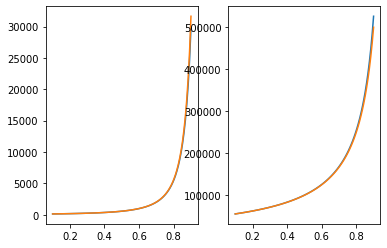

In [21]:
F=np.linspace(0.1,0.9,100)
LK=[]
LKT=[]
LG=[]
LGT=[]
for i in range(len(F)):
    f=F[i]
    Em=300
    mum=0.499
    Km=Em/(3-6*mum)
    Gm=Em/(2+2*mum)
    K=2*10**9
    G=3*10**9
    inclusion=Inclusion(0, {"K":K, "G":G}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    model = Differential_Scheme()
    Ch=model.compute_h_behavior(microstructure)
    LK.append(Ch['K'])
    LG.append(Ch['G'])
    LGT.append(Gm/(1-f)**(5/2))
    LKT.append(Km/(1-f))

plt.subplot(1,2,1) 
plt.plot(F,LG)
plt.plot(F,LGT)
plt.subplot(1,2,2) 
plt.plot(F,LK)
plt.plot(F,LKT)
plt.show()

### Inclusion rigide, mu=0,2 et concentration pas trop élevée

Référence :  [Christensen,  R.M.,  1990.  A critical evaluation for a class of micromechanics models].

Equation (19) p7

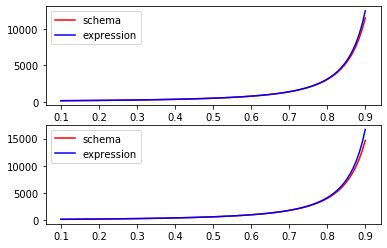

In [52]:
F=np.linspace(0.1,0.9,100)
LK=[]
LKT=[]
LG=[]
LGT=[]
for i in range(len(F)):
    f=F[i]
    Em=300
    mum=0.2
    Km=Em/(3-6*mum)
    Gm=Em/(2+2*mum)
    K=2*10**5
    G=3*10**5
    inclusion=Inclusion(0, {"K":K, "G":G}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    model = Differential_Scheme()
    Ch=model.compute_h_behavior(microstructure)
    LK.append(Ch['K'])
    LG.append(Ch['G'])
    LGT.append(Gm/(1-f)**2)
    LKT.append(Km/(1-f)**2)

plt.subplot(2,1,1) 
plt.plot(F,LG,'r',label='schema')
plt.plot(F,LGT,'b',label='expression')
plt.legend()
plt.subplot(2,1,2) 
plt.plot(F,LK,'r',label='schema')
plt.plot(F,LKT,'b',label='expression')
plt.legend()
plt.show()

### Haute concentration et matrice incompressible inclusion parfaitement rigide

Référence :  [Christensen,  R.M.,  1990.  A critical evaluation for a class of micromechanics models].

Equation (29) p8

20000000000.000755 9993333333333.334


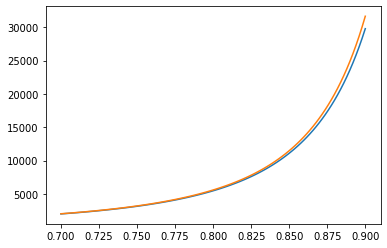

In [24]:
F=np.linspace(0.7,0.9,100)
LK=[]
LKT=[]
LG=[]
LGT=[]
for i in range(len(F)):
    f=F[i]
    Em=300
    mum=0.499
    Km=Em/(3-6*mum)
    Gm=Em/(2+2*mum)
    K=10**15
    G=10**15
    inclusion=Inclusion(0, {"K":K, "G":G}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    model = Differential_Scheme()
    Ch=model.compute_h_behavior(microstructure)
    LG.append(Ch['G'])
    LGT.append(Gm/(1-f)**(5/2))
print(K/Km,G/Gm)
plt.plot(F,LG)
plt.plot(F,LGT)
plt.show()

### Haute concentration et inclusion parfaitement rigide PAS OK

Référence :  [Christensen,  R.M.,  1990.  A critical evaluation for a class of micromechanics models].

Equation (28) p8 on devrait trouver un rapport constant de 1.3333

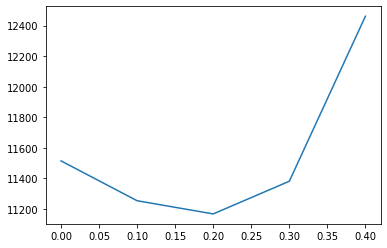

In [27]:
Mu=[0,0.1,0.2,0.3,0.4]
Fraction=[]
for i in range(len(Mu)):
    f=0.99999
    Em=300
    mum=Mu[i]
    Km=Em/(3-6*mum)
    Gm=Em/(2+2*mum)
    K=10**15
    G=2**15
    inclusion=Inclusion(0, {"K":K, "G":G}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    model = Differential_Scheme()
    Ch=model.compute_h_behavior(microstructure)
    Fraction.append(Ch['K']/Ch['G'])
plt.plot(Mu,Fraction)
plt.show()

# Schéma de Mori-Tanaka
### Inclusion rigide

Référence :  [Christensen,  R.M.,  1990.  A critical evaluation for a class of micromechanics models].

Equation (64) p15

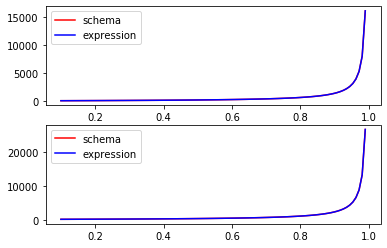

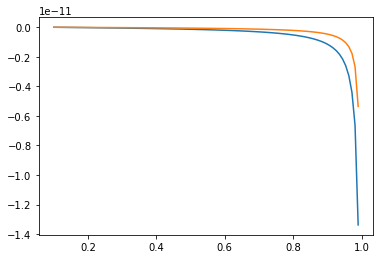

In [5]:
F=np.linspace(0.1,0.99,99)
LK=[]
LKT=[]
LG=[]
LGT=[]
for i in range(1,100):
    f=i/100
    Em=200
    mum=0.3
    Km=Em/(3-6*mum)
    Gm=Em/(2+2*mum)
    K=2*10**15
    G=3*10**15
    inclusion=Inclusion(0, {"K":K, "G":G}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    model = Mori_Tanaka()
    Ch=model.compute_h_behavior(microstructure)
    LK.append(Ch['K'])
    LG.append(Ch['G'])
    LGT.append(Gm*(1+f/(1-f)*(1+(9*Km+8*Gm)/(6*Km+12*Gm))))
    LKT.append(Km*(1+f/(1-f)*(1+4*Gm/(3*Km))))
    
plt.subplot(2,1,1) 
plt.plot(F,LG,'r',label='schema')
plt.plot(F,LGT,'b',label='expression')
plt.legend()
plt.subplot(2,1,2) 
plt.plot(F,LK,'r',label='schema')
plt.plot(F,LKT,'b',label='expression')
plt.legend()
plt.show()
Kdiff=(np.array(LK)-np.array(LKT))/np.array(LK)
Gdiff=(np.array(LG)-np.array(LGT))/np.array(LG)
plt.plot(F,Kdiff)
plt.plot(F,Gdiff)
plt.show()


### Inclusion rigide et matrice incompressible

Référence :  [Christensen,  R.M.,  1990.  A critical evaluation for a class of micromechanics models].

Equation (65) p15

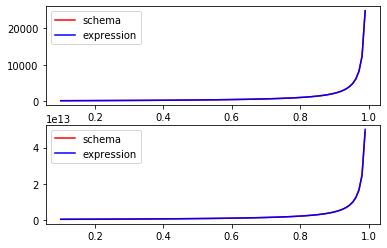

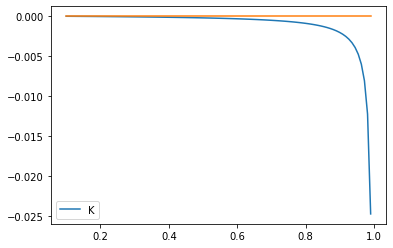

In [9]:
F=np.linspace(0.1,0.99,99)
LK=[]
LKT=[]
LG=[]
LGT=[]
for i in range(1,100):
    f=i/100
    Em=300
    mum=0.4999999999
    Km=Em/(3-6*mum)
    Gm=Em/(2+2*mum)
    K=2*10**15
    G=3*10**15
    inclusion=Inclusion(0, {"K":K, "G":G}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    model = Mori_Tanaka()
    Ch=model.compute_h_behavior(microstructure)
    LK.append(Ch['K'])
    LG.append(Ch['G'])
    LGT.append(Gm*(1+3*f/2)/(1-f))
    LKT.append(Km/(1-f))
    
plt.subplot(2,1,1) 
plt.plot(F,LG,'r',label='schema')
plt.plot(F,LGT,'b',label='expression')
plt.legend()
plt.subplot(2,1,2) 
plt.plot(F,LK,'r',label='schema')
plt.plot(F,LKT,'b',label='expression')
plt.legend()
plt.show()
Kdiff=(np.array(LK)-np.array(LKT))/np.array(LK)
Gdiff=(np.array(LG)-np.array(LGT))/np.array(LG)
plt.plot(F,Kdiff,label='K')
plt.plot(F,Gdiff)
plt.legend()
plt.show()

### Concentration élévées (f->1) et matrice compressible

Référence :  [Christensen,  R.M.,  1990.  A critical evaluation for a class of micromechanics models].

Table 2 p16

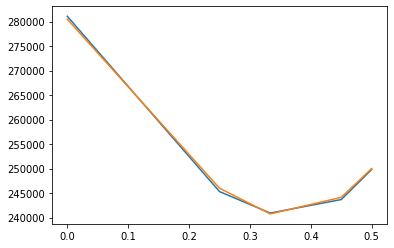

No handles with labels found to put in legend.


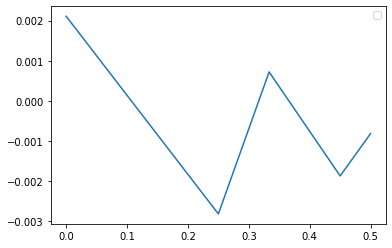

In [11]:
Mu=[0,1/4,1/3,0.45,0.4999]
Alpha=[1.87,2.05,2.14,2.36,2.5]
LG=[]
LGT=[]

for i in range(len(Mu)):
    f=0.999
    Em=300
    mum=Mu[i]
    Km=Em/(3-6*mum)
    Gm=Em/(2+2*mum)
    K=2*10**9
    G=3*10**9
    inclusion=Inclusion(0, {"K":K, "G":G}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    model = Mori_Tanaka()
    Ch=model.compute_h_behavior(microstructure)
    LG.append(Ch['G'])
    LGT.append(Gm*Alpha[i]/(1-f))
    
plt.plot(Mu,LG)
plt.plot(Mu,LGT)
plt.show()
Gdiff=(np.array(LG)-np.array(LGT))/np.array(LG)
plt.plot(Mu,Gdiff)
plt.legend()
plt.show()

### Cas particulier : mu=1/5, inclusion rigide comparaison des modèles Mori-Tanaka et Differentiel

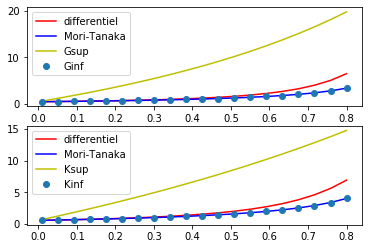

In [57]:
F=np.linspace(0.01,0.8,20)
Kdiff,Gdiff, KMT,GMT,Kinf,Ksup,Gsup,Ginf = [],[],[],[],[],[],[],[]
for i in range(len(F)):
    f=F[i]
    Em=1
    mum=0.2
    Km=Em/(3-6*mum)
    Gm=Em/(2+2*mum)
    K=20
    G=30
    inclusion=Inclusion(0, {"K":K, "G":G}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    Bounds=microstructure.Hashin_bounds()
    Gsup.append(Bounds['Gsup'])
    Ginf.append(Bounds['Ginf'])
    Ksup.append(Bounds['Ksup'])
    Kinf.append(Bounds['Kinf'])
    
    modeldiff = Differential_Scheme()
    Chdiff=modeldiff.compute_h_behavior(microstructure)
    Kdiff.append(Chdiff['K'])
    Gdiff.append(Chdiff['G'])
    
    modelmt = Mori_Tanaka()
    Chmt = modelmt.compute_h_behavior(microstructure)
    GMT.append(Chmt['G'])
    KMT.append(Chmt['K'])
    

plt.subplot(2,1,1) 
plt.plot(F,Gdiff,'r',label='differentiel')
plt.plot(F,GMT,'b',label='Mori-Tanaka')
plt.plot(F,Gsup,'y',label='Gsup')
plt.plot(F,Ginf,'o',label='Ginf')
plt.legend()
plt.subplot(2,1,2) 
plt.plot(F,Kdiff,'r',label='differentiel')
plt.plot(F,KMT,'b',label='Mori-Tanaka')
plt.plot(F,Ksup,'y',label='Ksup')
plt.plot(F,Kinf,'o',label='Kinf')
plt.legend()
plt.show()

## Bornes de Hashin-Shtrickman

### Test du modèle des bornes de Hashin-Shtrickman pour K,G>Km,Gm

Référence : [Hashin, Z., and Shtrikman, S., 1963.  A Variational Approach to the Theory of the Elastic Behaviour of Multiphase Materials.J. Mech.  Phys.  Solids, 11, 127–140].

Datas : Fig 1 and 2 p136

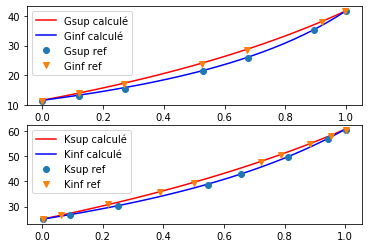

In [28]:
## Données : 
K,G = 60.7,41.8
Km,Gm = 25,11.5

FGsup = [0.000771508, 0.122418131, 0.272279371, 0.530682701, 0.676225717, 0.893925994, 1.000617946]
Gsup = [11.37606358, 13.08246844, 15.49789621, 21.45086489, 25.97007948, 35.35147265, 41.64721833]
FGinf = [0.000771508,0.120567993, 0.26919519, 0.526210916, 0.673759482, 0.919211841, 0.996917669]
Ginf = [11.37606358,13.83048153, 16.91603553, 23.81178121, 28.44787284, 38.00065451, 41.61608228]
FKsup = [0.00267784, 0.090936685, 0.249534451, 0.546089385, 0.657821229, 0.811297952, 0.944599628, 1.004189944]
Ksup = [24.95709828, 26.84864275, 30.24964119, 38.6349454, 42.82371295, 49.65678627, 56.8174727, 60.51482059]
FKinf = [0.004422719, 0.062849162, 0.217877095, 0.389664804, 0.502793296, 0.722843575, 0.788640596, 0.884078212, 0.954376164, 1.003724395]
Kinf =[25.0975039, 26.65366615, 30.88923557, 35.75663027, 39.38377535, 47.78471139, 50.54602184, 54.75819033, 58.01092044, 60.56939158]

F=np.linspace(0.0001,0.999,30)
kinf,ksup,gsup,ginf = [],[],[],[]
for i in range(len(F)):
    f = F[i]
    inclusion=Inclusion(0, {"K":K, "G":G}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    Bounds=microstructure.Hashin_bounds()
    gsup.append(Bounds['Gsup'])
    ginf.append(Bounds['Ginf'])
    ksup.append(Bounds['Ksup'])
    kinf.append(Bounds['Kinf'])

plt.subplot(2,1,1) 
plt.plot(F,gsup,'r',label='Gsup calculé')
plt.plot(F,ginf,'b',label='Ginf calculé')
plt.plot(FGsup,Gsup,'o',label='Gsup ref')
plt.plot(FGinf,Ginf,'v',label='Ginf ref')
plt.legend()

plt.subplot(2,1,2) 
plt.plot(F,ksup,'r',label='Ksup calculé')
plt.plot(F,kinf,'b',label='Kinf calculé')
plt.plot(FKsup,Ksup,'o',label='Ksup ref')
plt.plot(FKinf,Kinf,'v',label='Kinf ref')
plt.legend()

plt.show()

### Calcul "standard" des bornes de Hashin-Shtrickman

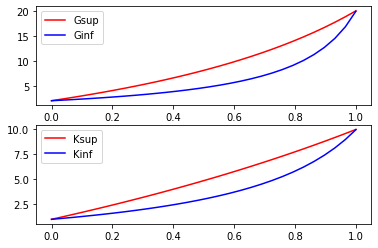

In [70]:
F=np.linspace(0.0001,0.999,30)
Kinf,Ksup,Gsup,Ginf = [],[],[],[]
for i in range(len(F)):
    K,G = 10,20
    Km,Gm = 1,2
    f = F[i]
    inclusion=Inclusion(0, {"K":K, "G":G}, 1)
    microstructure = Microstructure({"K":Km, "G":Gm}, {inclusion:f})
    Bounds=microstructure.Hashin_bounds()
    Gsup.append(Bounds['Gsup'])
    Ginf.append(Bounds['Ginf'])
    Ksup.append(Bounds['Ksup'])
    Kinf.append(Bounds['Kinf'])

plt.subplot(2,1,1) 
plt.plot(F,Gsup,'r',label='Gsup')
plt.plot(F,Ginf,'b',label='Ginf')
plt.legend()

plt.subplot(2,1,2) 
plt.plot(F,Ksup,'r',label='Ksup')
plt.plot(F,Kinf,'b',label='Kinf')
plt.legend()

plt.show()